In [1]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore #for outlier
from scipy import stats # for plot normal distribution

In [2]:
bucket = 'sagemaker-studio-dg14br0e9t9/dataset'   
data_key = 'nyc.csv'
dl = 's3://{}/{}'.format(bucket, data_key)
df = pd.read_csv(dl)

In [3]:
# Read the data
#df= pd.read_csv('/kaggle/input/nycproperty/Merged.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181037 entries, 0 to 181036
Data columns (total 21 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   BOROUGH                        181028 non-null  float64
 1   NEIGHBORHOOD                   181028 non-null  object 
 2   BUILDING CLASS CATEGORY        181028 non-null  object 
 3   TAX CLASS AT PRESENT           180785 non-null  object 
 4   BLOCK                          181028 non-null  float64
 5   LOT                            181028 non-null  float64
 6   EASE-MENT                      0 non-null       float64
 7   BUILDING CLASS AT PRESENT      180785 non-null  object 
 8   ADDRESS                        181028 non-null  object 
 9   APARTMENT NUMBER               44756 non-null   object 
 10  ZIP CODE                       181015 non-null  float64
 11  RESIDENTIALUNITS               143649 non-null  float64
 12  COMMERCIALUNITS               

In [5]:
df.columns = [c.replace('\n', '') for c in df.columns]
pd.set_option('display.max_columns', None)  # or 1000
df.head()

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,EASE-MENT,BUILDING CLASS AT PRESENT,ADDRESS,APARTMENT NUMBER,ZIP CODE,RESIDENTIALUNITS,COMMERCIALUNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASSAT TIME OF SALE,SALE PRICE,SALE DATE
0,1.0,ALPHABET CITY,02 TWO FAMILY DWELLINGS,1,377.0,72.0,NaN,B9,231 EAST 7TH,NaN,10009.0,2.0,0.0,2.0,1718.0,5154.0,1901.0,1.0,B9,0.0,02-10-2020
1,1.0,ALPHABET CITY,03 THREE FAMILY DWELLINGS,1,377.0,66.0,NaN,C0,243 EAST 7TH STREET,NaN,10009.0,3.0,0.0,3.0,2381.0,3084.0,1899.0,1.0,C0,0.0,31-10-2020
2,1.0,ALPHABET CITY,03 THREE FAMILY DWELLINGS,1,377.0,66.0,NaN,C0,243 EAST 7TH STREET,NaN,10009.0,3.0,0.0,3.0,2381.0,3084.0,1899.0,1.0,C0,4350000.0,16-07-2020
3,1.0,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,372.0,10.0,NaN,C7,274 EAST 3RD,NaN,10009.0,9.0,1.0,10.0,2021.0,6445.0,1900.0,2.0,C7,0.0,27-12-2020
4,1.0,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,374.0,1.0,NaN,C7,301-303 EAST 4TH STREET,NaN,10009.0,8.0,2.0,10.0,1501.0,6929.0,1900.0,2.0,C7,3672530.0,24-11-2020


### Data Cleaning and Data Preprocessing 

In [6]:
## Duplicates

In [7]:
#Delete the duplicates and check that it worked
df = df.drop_duplicates(df.columns, keep='last')
sum(df.duplicated(df.columns))

0

In [8]:
## Uniqueness

In [9]:
#Check for the number of unique values for every column 
for i in df.columns:
  print(str(i) + ":" + str(df[i].nunique()))

BOROUGH:5
NEIGHBORHOOD:255
BUILDING CLASS CATEGORY:44
TAX CLASS AT PRESENT:10
BLOCK:12739
LOT:3368
EASE-MENT:0
BUILDING CLASS AT PRESENT:166
ADDRESS:153455
APARTMENT NUMBER:6617
ZIP CODE:195
RESIDENTIALUNITS:179
COMMERCIALUNITS:71
TOTAL UNITS:193
LAND SQUARE FEET:7883
GROSS SQUARE FEET:7273
YEAR BUILT:183
TAX CLASS AT TIME OF SALE:3
BUILDING CLASSAT TIME OF SALE:166
SALE PRICE:13348
SALE DATE:731


In [10]:
## Data type transformation 

Since there is no information in EASE-MENT columns, we will drop it initially. We will also drop the SALE DATE column as we are not considering the effect of time on the sale price. 

In [11]:
#Converting columns to respective datatype
categoricalData = ['BOROUGH','TAX CLASS AT PRESENT','BUILDING CLASS CATEGORY',
                    'TAX CLASS AT TIME OF SALE',
                    'BUILDING CLASS AT PRESENT',
                    'BUILDING CLASSAT TIME OF SALE']
for each in categoricalData:
    df[each] = df[each].astype('category')
df['LAND SQUARE FEET'] = pd.to_numeric(df['LAND SQUARE FEET'], errors='coerce')
df['GROSS SQUARE FEET']= pd.to_numeric(df['GROSS SQUARE FEET'], errors='coerce')
df['SALE PRICE'] = df['SALE PRICE'].replace('[CA\$,]', '', regex=True).astype(float) * 0.77 # convert to US dollars 
df = df.drop(columns=["SALE DATE", "EASE-MENT"])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 161130 entries, 0 to 181036
Data columns (total 19 columns):
 #   Column                         Non-Null Count   Dtype   
---  ------                         --------------   -----   
 0   BOROUGH                        161129 non-null  category
 1   NEIGHBORHOOD                   161129 non-null  object  
 2   BUILDING CLASS CATEGORY        161129 non-null  category
 3   TAX CLASS AT PRESENT           160918 non-null  category
 4   BLOCK                          161129 non-null  float64 
 5   LOT                            161129 non-null  float64 
 6   BUILDING CLASS AT PRESENT      160918 non-null  category
 7   ADDRESS                        161129 non-null  object  
 8   APARTMENT NUMBER               39509 non-null   object  
 9   ZIP CODE                       161117 non-null  float64 
 10  RESIDENTIALUNITS               126093 non-null  float64 
 11  COMMERCIALUNITS                106979 non-null  float64 
 12  TOTAL UNITS     

In [12]:
## Missing values

In [13]:
# Drop LAND SQUARE FEET = 0, GROSS SQUARE FEET = 0, YEAR BUILT = 0   
df = df[df['LAND SQUARE FEET'] > 0]
df = df[df['GROSS SQUARE FEET'] > 0]
df = df[df['YEAR BUILT'] > 0]  
#Drop the missing values
df.dropna(how='all',axis=1,inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 85843 entries, 0 to 181033
Data columns (total 19 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   BOROUGH                        85843 non-null  category
 1   NEIGHBORHOOD                   85843 non-null  object  
 2   BUILDING CLASS CATEGORY        85843 non-null  category
 3   TAX CLASS AT PRESENT           85843 non-null  category
 4   BLOCK                          85843 non-null  float64 
 5   LOT                            85843 non-null  float64 
 6   BUILDING CLASS AT PRESENT      85843 non-null  category
 7   ADDRESS                        85843 non-null  object  
 8   APARTMENT NUMBER               781 non-null    object  
 9   ZIP CODE                       85843 non-null  float64 
 10  RESIDENTIALUNITS               85843 non-null  float64 
 11  COMMERCIALUNITS                85843 non-null  float64 
 12  TOTAL UNITS                    

In [14]:
##Check whether dropping nan worked 
df.isnull().sum()

BOROUGH                              0
NEIGHBORHOOD                         0
BUILDING CLASS CATEGORY              0
TAX CLASS AT PRESENT                 0
BLOCK                                0
LOT                                  0
BUILDING CLASS AT PRESENT            0
ADDRESS                              0
APARTMENT NUMBER                 85062
ZIP CODE                             0
RESIDENTIALUNITS                     0
COMMERCIALUNITS                      0
TOTAL UNITS                          0
LAND SQUARE FEET                     0
GROSS SQUARE FEET                    0
YEAR BUILT                           0
TAX CLASS AT TIME OF SALE            0
BUILDING CLASSAT TIME OF SALE        0
SALE PRICE                           0
dtype: int64

In [15]:
## Outliers

In this case, we will use Z score to detect the outliers in the columns of LAND SQUARE FEET, GROSS SQUARE FEET and SALE PRICE. 
Z score is a significant measure that tells how much a number is above or below the mean of the dataset in terms of standard deviation. We set the threshold=3

In [16]:
df['landSquare_zscore']=zscore(df['LAND SQUARE FEET'])
df.loc[df['landSquare_zscore'].abs()<=3]
print("The count of outliers in LAND SQUARE FEET is: {}".format(len((np.where(zscore(df['LAND SQUARE FEET']) > 3)[0]))))

df['grossSquare_zscore']=zscore(df['GROSS SQUARE FEET'])
df.loc[df['grossSquare_zscore'].abs()<=3]
print("The count of outliers in GROSS SQUARE FEET is: {}".format(len((np.where(zscore(df['GROSS SQUARE FEET']) > 3)[0]))))

df['salePrice_zscore']=zscore(df['SALE PRICE'])
df.loc[df['salePrice_zscore'].abs()<=3]
print("The count of outliers in SALE PRICE is: {}".format(len((np.where(zscore(df['SALE PRICE']) > 3)[0]))))

The count of outliers in LAND SQUARE FEET is: 47
The count of outliers in GROSS SQUARE FEET is: 462
The count of outliers in SALE PRICE is: 340


### Exploratory Data Analysis

### Feature Engineering

In [17]:
df['AGE'] = 2021 - df['YEAR BUILT']

# is the building pre or post war?
df['AGE_CATEGORY'] = np.where(df['AGE']>=76,1,0)

df['AGE_CATEGORY'] = df['AGE_CATEGORY'].astype('category')

df.head()

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,BUILDING CLASS AT PRESENT,ADDRESS,APARTMENT NUMBER,ZIP CODE,RESIDENTIALUNITS,COMMERCIALUNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASSAT TIME OF SALE,SALE PRICE,landSquare_zscore,grossSquare_zscore,salePrice_zscore,AGE,AGE_CATEGORY
0,1.0,ALPHABET CITY,02 TWO FAMILY DWELLINGS,1,377.0,72.0,B9,231 EAST 7TH,NaN,10009.0,2.0,0.0,2.0,1718.0,5154.0,1901.0,1.0,B9,0.0,-0.040307,-0.013784,-0.122336,120.0,1
1,1.0,ALPHABET CITY,03 THREE FAMILY DWELLINGS,1,377.0,66.0,C0,243 EAST 7TH STREET,NaN,10009.0,3.0,0.0,3.0,2381.0,3084.0,1899.0,1.0,C0,0.0,-0.032203,-0.052881,-0.122336,122.0,1
2,1.0,ALPHABET CITY,03 THREE FAMILY DWELLINGS,1,377.0,66.0,C0,243 EAST 7TH STREET,NaN,10009.0,3.0,0.0,3.0,2381.0,3084.0,1899.0,1.0,C0,3349500.0,-0.032203,-0.052881,0.362354,122.0,1
3,1.0,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,372.0,10.0,C7,274 EAST 3RD,NaN,10009.0,9.0,1.0,10.0,2021.0,6445.0,1900.0,2.0,C7,0.0,-0.036603,0.010600,-0.122336,121.0,1
4,1.0,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,374.0,1.0,C7,301-303 EAST 4TH STREET,NaN,10009.0,8.0,2.0,10.0,1501.0,6929.0,1900.0,2.0,C7,2827848.1,-0.042960,0.019741,0.286868,121.0,1


In [18]:
df.drop('AGE',axis=1,inplace=True)

## Converting Borough column to name of each property where it is located.

In [19]:
df['BOROUGH'].unique()

[1.0, 2.0, 4.0, 3.0, 5.0]
Categories (5, float64): [1.0, 2.0, 4.0, 3.0, 5.0]

In [20]:
df['BOROUGH'] = df['BOROUGH'].map({1.0:"Manhattan",
                                 2.0:"Bronx",
                                 3.0:"Brooklyn",
                                 4.0:"Queens",
                                 5.0:"Staten Island"})
df['BOROUGH'].unique()

['Manhattan', 'Bronx', 'Queens', 'Brooklyn', 'Staten Island']
Categories (5, object): ['Manhattan', 'Bronx', 'Queens', 'Brooklyn', 'Staten Island']

### Target Variable[Sale Price]

##### Visualization of Raw Data

Calculating mean, median and mode for each column in dataframe

In [21]:
df.describe()

,BLOCK,LOT,ZIP CODE,RESIDENTIALUNITS,COMMERCIALUNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,SALE PRICE,landSquare_zscore,grossSquare_zscore,salePrice_zscore
count,85843.000000,85843.000000,85843.000000,85843.000000,85843.000000,85843.000000,8.584300e+04,8.584300e+04,85843.000000,8.584300e+04,8.584300e+04,8.584300e+04,8.584300e+04
mean,5581.782277,64.660368,11043.888541,3.875249,0.290950,4.166199,5.015620e+03,5.883806e+03,1942.050441,8.454169e+05,3.005507e-15,-3.134065e-16,-2.602268e-14
std,3774.969853,139.831246,458.667309,39.142485,8.801413,40.244495,8.181287e+04,5.294524e+04,31.140136,6.910645e+06,1.000006e+00,1.000006e+00,1.000006e+00
min,1.000000,1.000000,10001.000000,0.000000,0.000000,0.000000,3.500000e+01,1.000000e+00,1018.000000,0.000000e+00,-6.087855e-02,-1.111118e-01,-1.223362e-01
25%,2454.500000,19.000000,10469.000000,1.000000,0.000000,1.000000,2.000000e+03,1.408000e+03,1920.000000,0.000000e+00,-3.686018e-02,-8.453701e-02,-1.223362e-01
50%,5235.000000,39.000000,11224.000000,2.000000,0.000000,2.000000,2.500000e+03,1.974000e+03,1931.000000,3.696000e+05,-3.074864e-02,-7.384666e-02,-6.885315e-02
75%,7867.000000,64.000000,11375.000000,2.000000,0.000000,2.000000,4.000000e+03,2.800000e+03,1960.000000,6.660500e+05,-1.241401e-02,-5.824554e-02,-2.595531e-02
max,16330.000000,8165.000000,11695.000000,8764.000000,2261.000000,8812.000000,7.649136e+06,8.942176e+06,2021.000000,7.531296e+08,9.343475e+01,1.687847e+02,1.088594e+02


In [22]:
df.columns

Index(['BOROUGH', 'NEIGHBORHOOD', 'BUILDING CLASS CATEGORY',
       'TAX CLASS AT PRESENT', 'BLOCK', 'LOT', 'BUILDING CLASS AT PRESENT',
       'ADDRESS', 'APARTMENT NUMBER', 'ZIP CODE', 'RESIDENTIALUNITS',
       'COMMERCIALUNITS', 'TOTAL UNITS', 'LAND SQUARE FEET',
       'GROSS SQUARE FEET', 'YEAR BUILT', 'TAX CLASS AT TIME OF SALE',
       'BUILDING CLASSAT TIME OF SALE', 'SALE PRICE', 'landSquare_zscore',
       'grossSquare_zscore', 'salePrice_zscore', 'AGE_CATEGORY'],
      dtype='object')

In [23]:
N = 'Nominal'
O = 'Ordinal'
I = 'Interval'
R = "Ratio"

In [24]:
NOIR_Classification={"BOROUGH":N,
                    "NEIGHBORHOOD":N,
                    "BUILDING CLASS CATEGORY":O,
                    "TAX CLASS AT PRESENT":O,
                    "BLOCK":N,
                    "LOT":N,
                    "BUILDING CLASS AT PRESENT":N,
                    "ADDRESS":N,
                    "APARTMENT NUMBER":N,
                    "ZIP CODE":N,
                    "RESIDENTIALUNITS":N,
                    "COMMERCIALUNITS":N,
                    "TOTAL UNITS":N,
                    "LAND SQUARE FEET":N,
                    "GROSS SQUARE FEET":N,
                    "YEAR BUILT":O,
                    "TAX CLASS AT TIME OF SALE":O,
                    "BUILDING CLASSAT TIME OF SALE":N,
                    "SALE PRICE":N,
                    "SALE DATE":O,
                     'AGE': R,
                     'AGE_CATEGORY': O

                   }

In [25]:
for key,value in NOIR_Classification.items():
    print(f"Column: {key}\t\t\t Classification Type :{value}")

Column: BOROUGH			 Classification Type :Nominal
Column: NEIGHBORHOOD			 Classification Type :Nominal
Column: BUILDING CLASS CATEGORY			 Classification Type :Ordinal
Column: TAX CLASS AT PRESENT			 Classification Type :Ordinal
Column: BLOCK			 Classification Type :Nominal
Column: LOT			 Classification Type :Nominal
Column: BUILDING CLASS AT PRESENT			 Classification Type :Nominal
Column: ADDRESS			 Classification Type :Nominal
Column: APARTMENT NUMBER			 Classification Type :Nominal
Column: ZIP CODE			 Classification Type :Nominal
Column: RESIDENTIALUNITS			 Classification Type :Nominal
Column: COMMERCIALUNITS			 Classification Type :Nominal
Column: TOTAL UNITS			 Classification Type :Nominal
Column: LAND SQUARE FEET			 Classification Type :Nominal
Column: GROSS SQUARE FEET			 Classification Type :Nominal
Column: YEAR BUILT			 Classification Type :Ordinal
Column: TAX CLASS AT TIME OF SALE			 Classification Type :Ordinal
Column: BUILDING CLASSAT TIME OF SALE			 Classification Type :Nomin

In [26]:
df['SALE PRICE'].describe()

count    8.584300e+04
mean     8.454169e+05
std      6.910645e+06
min      0.000000e+00
25%      0.000000e+00
50%      3.696000e+05
75%      6.660500e+05
max      7.531296e+08
Name: SALE PRICE, dtype: float64

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Skewness: 56.121476


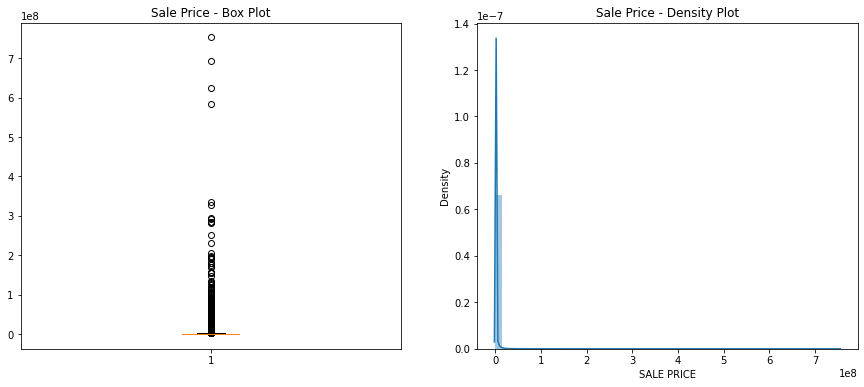

In [27]:
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.boxplot(df['SALE PRICE'])
plt.title('Sale Price - Box Plot')
plt.subplot(1,2,2)
sns.distplot(df['SALE PRICE'])
plt.title('Sale Price - Density Plot')
# Skewness
print("Skewness: %f" % df['SALE PRICE'].skew())
plt.show()

##### Range set-up & Log-Transformation

In [28]:
# Sale price percentage = $0
len(df.loc[df['SALE PRICE'] == 0 ])/len(df)

0.40532134245075313

In [29]:
# Sale price percentage < $50000
len(df.loc[df['SALE PRICE'] < 50000])/len(df)

0.43128735016250597

In [30]:
# Sale price percentage > 12000000
len(df.loc[df['SALE PRICE'] > 12000000 ])/len(df)

0.00768845450415293

##### Observation: 

It is observed that a lot of sales occur with an absurdly small number: \\$0  most commonly ( 40%  of the sale price =  \\$0 ). 
On the basis of the original data resource, it is noted that these sales are in effect transfers of deeds between parties. For instance, the transfer of ownership of the house from parents to the child after the parents move out for retirement. To handle this situation, a reasonable range for the sale price will be set up. The instances for which the sale price is greater than \\$12M and less than \\$50000 will be removed since it will help eliminate the special cases. Following which, log transformation can be performed. 

In [31]:
#Removing rows where year_built is equal to zero because these rows can be considered as outliers
df = df[df['YEAR BUILT']!=0]

In [32]:
df

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,BUILDING CLASS AT PRESENT,ADDRESS,APARTMENT NUMBER,ZIP CODE,RESIDENTIALUNITS,COMMERCIALUNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASSAT TIME OF SALE,SALE PRICE,landSquare_zscore,grossSquare_zscore,salePrice_zscore,AGE_CATEGORY
0,Manhattan,ALPHABET CITY,02 TWO FAMILY DWELLINGS,1,377.0,72.0,B9,231 EAST 7TH,NaN,10009.0,2.0,0.0,2.0,1718.0,5154.0,1901.0,1.0,B9,0.00,-0.040307,-0.013784,-0.122336,1
1,Manhattan,ALPHABET CITY,03 THREE FAMILY DWELLINGS,1,377.0,66.0,C0,243 EAST 7TH STREET,NaN,10009.0,3.0,0.0,3.0,2381.0,3084.0,1899.0,1.0,C0,0.00,-0.032203,-0.052881,-0.122336,1
2,Manhattan,ALPHABET CITY,03 THREE FAMILY DWELLINGS,1,377.0,66.0,C0,243 EAST 7TH STREET,NaN,10009.0,3.0,0.0,3.0,2381.0,3084.0,1899.0,1.0,C0,3349500.00,-0.032203,-0.052881,0.362354,1
3,Manhattan,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,372.0,10.0,C7,274 EAST 3RD,NaN,10009.0,9.0,1.0,10.0,2021.0,6445.0,1900.0,2.0,C7,0.00,-0.036603,0.010600,-0.122336,1
4,Manhattan,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,374.0,1.0,C7,301-303 EAST 4TH STREET,NaN,10009.0,8.0,2.0,10.0,1501.0,6929.0,1900.0,2.0,C7,2827848.10,-0.042960,0.019741,0.286868,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181029,Staten Island,WOODROW,02 TWO FAMILY DWELLINGS,1,7349.0,82.0,B9,66 PHEASANT LANE,NaN,10309.0,2.0,0.0,2.0,2438.0,2178.0,1999.0,1.0,B9,169379.21,-0.031506,-0.069994,-0.097826,0
181030,Staten Island,WOODROW,02 TWO FAMILY DWELLINGS,1,7351.0,22.0,B2,22 HERRICK AVENUE,NaN,10309.0,2.0,0.0,2.0,4000.0,2400.0,2000.0,1.0,B2,0.00,-0.012414,-0.065801,-0.122336,0
181031,Staten Island,WOODROW,02 TWO FAMILY DWELLINGS,1,7355.0,79.0,B9,86 AMBASSADOR LANE,NaN,10309.0,2.0,0.0,2.0,2645.0,2250.0,2001.0,1.0,B9,423500.00,-0.028976,-0.068634,-0.061054,0
181032,Staten Island,WOODROW,02 TWO FAMILY DWELLINGS,1,7355.0,86.0,B9,106 AMBASSADOR LANE,NaN,10309.0,2.0,0.0,2.0,2562.0,2565.0,2001.0,1.0,B9,491645.00,-0.029991,-0.062684,-0.051193,0


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='SALE PRICE', ylabel='Density'>

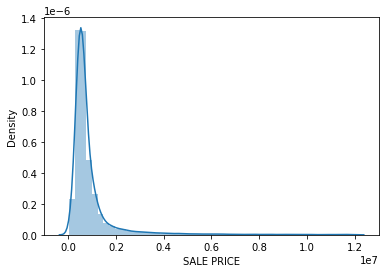

In [33]:
df = df[(df['SALE PRICE'] > 50000) & (df['SALE PRICE'] < 12000000)]
sns.distplot(df['SALE PRICE'])

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Sale Price - Box Plot')

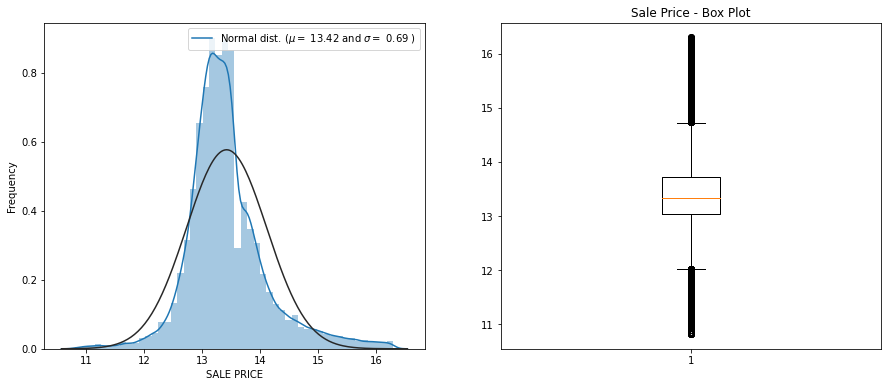

In [34]:
# log(x) transform

df["SALE PRICE"]=np.log(df["SALE PRICE"])

plt.subplots(figsize=(15,6))
plt.subplot(1,2,1)
sns.distplot(df["SALE PRICE"], fit = stats.norm)
plt.ylabel('Frequency')
(mu, sigma) = stats.norm.fit(df["SALE PRICE"])
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')

plt.subplot(1,2,2)
plt.boxplot(df['SALE PRICE'])
plt.title('Sale Price - Box Plot')

#### Feature Analysis and Selection 

In [35]:
df = df.drop(['salePrice_zscore', 'landSquare_zscore', 'grossSquare_zscore'],axis =1)
df.columns

Index(['BOROUGH', 'NEIGHBORHOOD', 'BUILDING CLASS CATEGORY',
       'TAX CLASS AT PRESENT', 'BLOCK', 'LOT', 'BUILDING CLASS AT PRESENT',
       'ADDRESS', 'APARTMENT NUMBER', 'ZIP CODE', 'RESIDENTIALUNITS',
       'COMMERCIALUNITS', 'TOTAL UNITS', 'LAND SQUARE FEET',
       'GROSS SQUARE FEET', 'YEAR BUILT', 'TAX CLASS AT TIME OF SALE',
       'BUILDING CLASSAT TIME OF SALE', 'SALE PRICE', 'AGE_CATEGORY'],
      dtype='object')

#### (i) Correlation 

<AxesSubplot:>

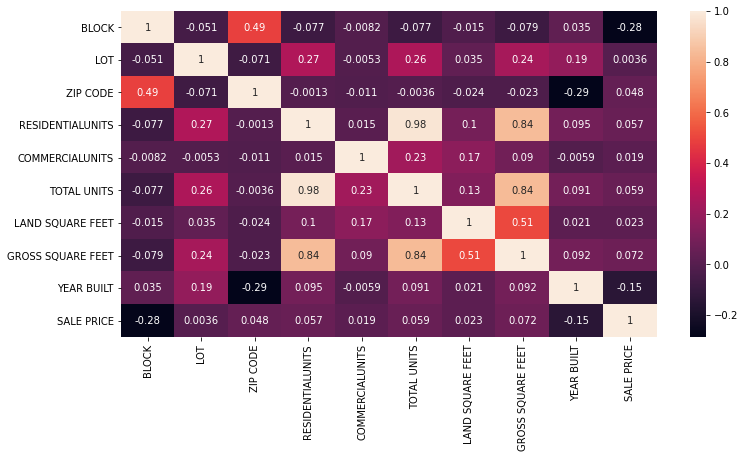

In [36]:
#Colinearity heatmap
corr = df.corr()
plt.figure(figsize=(12,6))
sns.heatmap(corr, annot=True)

#### (ii) Feature Analysis and Selection

a. BOROUGH

Explanation: The name of the borough in which the property is located.

1 = Bronx\
2 = Brooklyn\
3 = Manhattan\
4 = Queens\
5 = Staten Island

<AxesSubplot:title={'center':'Mean Sale Price in each BOROUGH'}, xlabel='BOROUGH'>

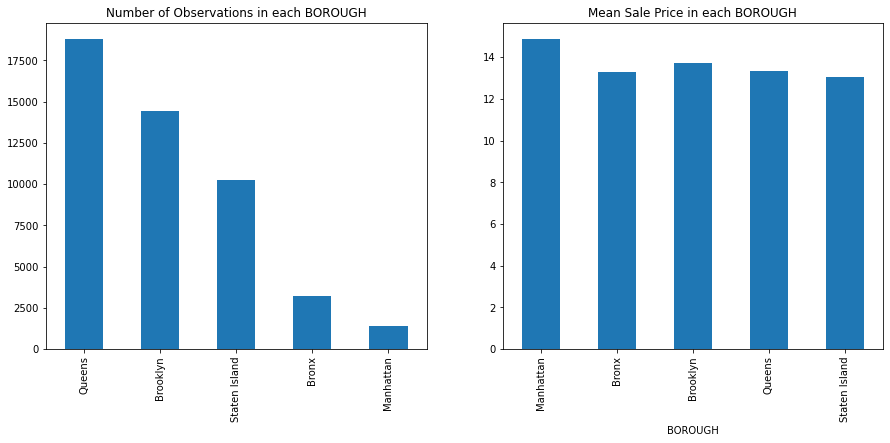

In [37]:
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.title("Number of Observations in each BOROUGH")
df['BOROUGH'].value_counts().plot(kind='bar')

# Average price by borough
plt.subplot(1,2,2)
plt.title("Mean Sale Price in each BOROUGH")
df.groupby('BOROUGH').mean()['SALE PRICE'].plot(kind = 'bar')

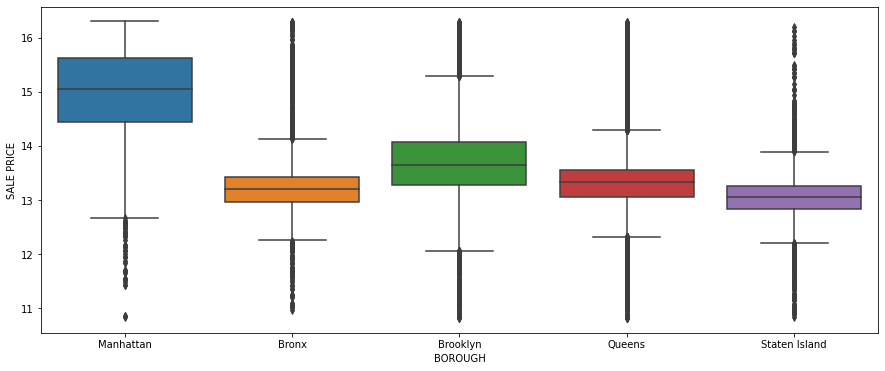

In [38]:
plt.figure(figsize=(15,6))
sns.boxplot(x=df['BOROUGH'].astype('category'), y = df['SALE PRICE'], data=pd.melt(df))
plt.show()

#### b. NEIGHBORHOOD

Explanation: While evaluating properties, the name of hte neighborhood is determined by the Department of Finance assessors. Although, the common name of the neighborhood is the same as designated by the Finance department, slight differences may occur when it comes to neighborhood boundary lines. It is also noted that a few sub-neighborhoods might not be included. 

Text(0, 0.5, 'Average sale price')

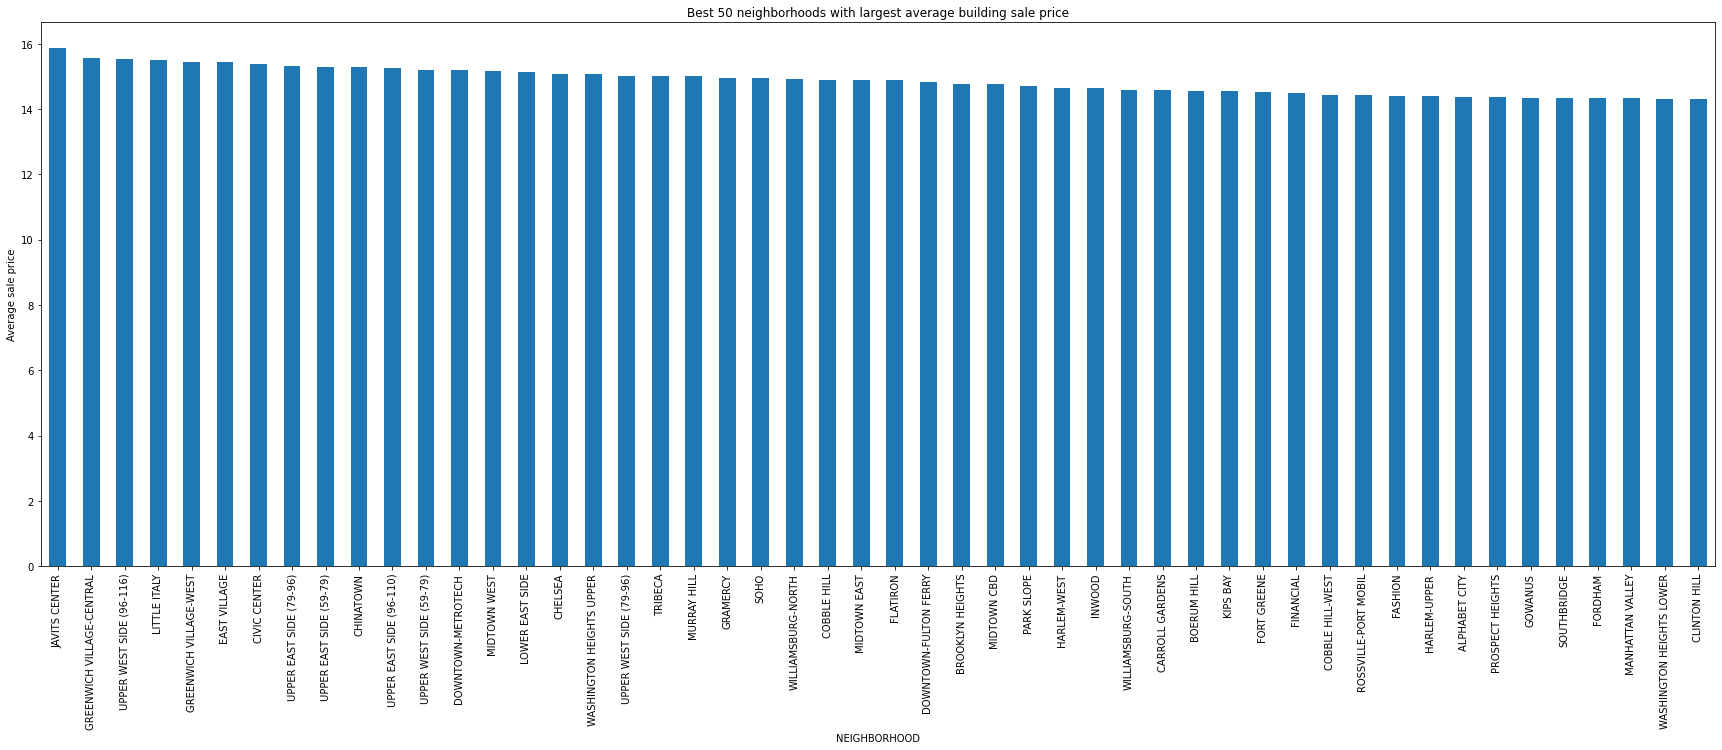

In [39]:
# Best 50 neighborhoods having largest average building sale price
plt.figure(figsize=(30,10))
df.groupby('NEIGHBORHOOD').mean()['SALE PRICE'].sort_values(ascending = False).head(50).plot(kind = 'bar')
plt.title("Best 50 neighborhoods with largest average building sale price")
plt.ylabel('Average sale price')

#### Building Class category

Explanation: To help the users of the Rolling Sales Files to identify similar properties by broad usage such as One Family Homes without having to look up Individual Buildign Classes, this filed is included. The files are sorted by Borough, Neighborhood, Block, Building Class Category and Lot.  

In [40]:
df['BUILDING CLASS CATEGORY'].unique()

['03 THREE FAMILY DWELLINGS', '07 RENTALS - WALKUP APARTMENTS', '14 RENTALS - 4-10 UNIT', '01 ONE FAMILY DWELLINGS', '02 TWO FAMILY DWELLINGS', ..., '35 INDOOR PUBLIC AND CULTURAL FACILITIES', '39 TRANSPORTATION FACILITIES', '27 FACTORIES', '36 OUTDOOR RECREATIONAL FACILITIES', '34 THEATRES']
Length: 23
Categories (23, object): ['03 THREE FAMILY DWELLINGS', '07 RENTALS - WALKUP APARTMENTS', '14 RENTALS - 4-10 UNIT', '01 ONE FAMILY DWELLINGS', ..., '39 TRANSPORTATION FACILITIES', '27 FACTORIES', '36 OUTDOOR RECREATIONAL FACILITIES', '34 THEATRES']

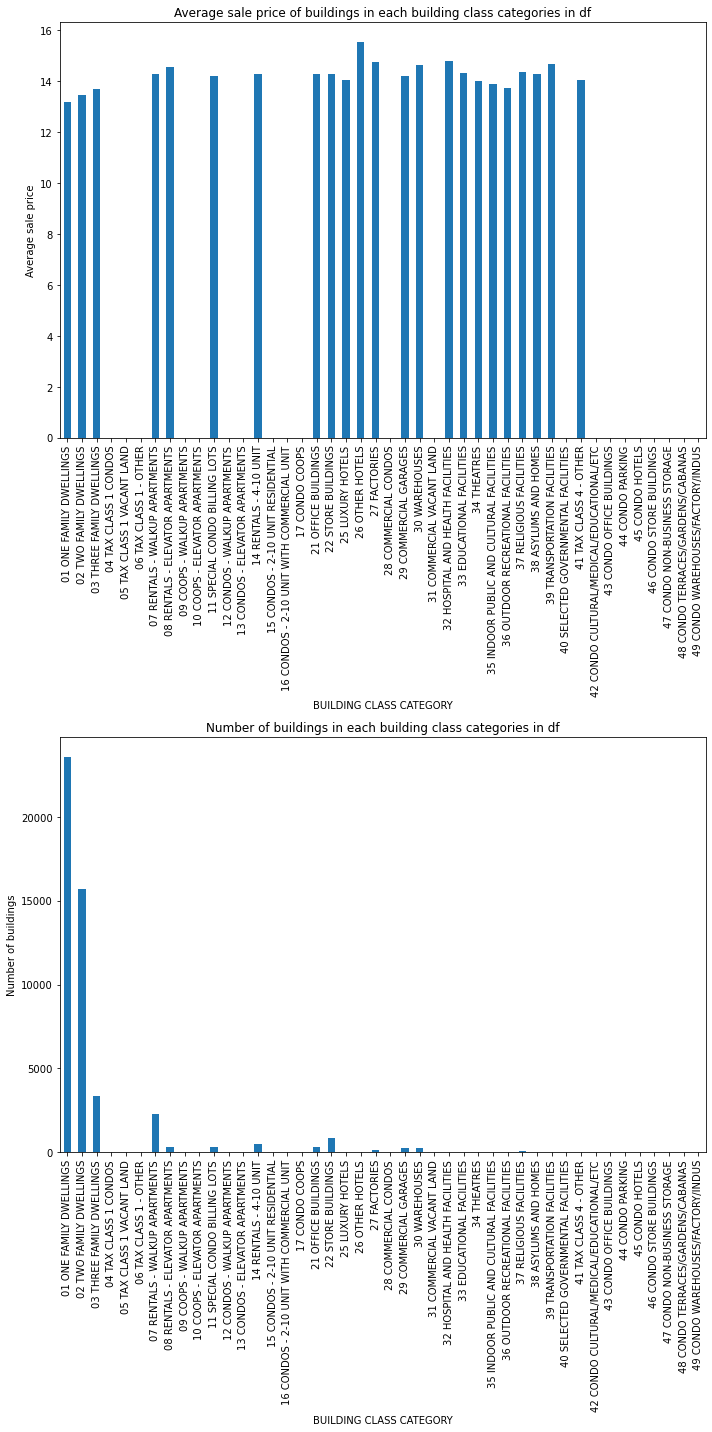

In [41]:
fig, axs = plt.subplots(2, 1, figsize=(10,20), sharey=True)
# Average price by building class category
plt.subplot(211)
df.groupby('BUILDING CLASS CATEGORY').mean()['SALE PRICE'].plot(kind = 'bar')
plt.title('Average sale price of buildings in each building class categories in df')
plt.ylabel('Average sale price')

# number of buildings by building class category
plt.subplot(212)
df.groupby('BUILDING CLASS CATEGORY').size().plot(kind = 'bar')
plt.title('Number of buildings in each building class categories in df')
plt.ylabel('Number of buildings')

plt.tight_layout()
plt.show()

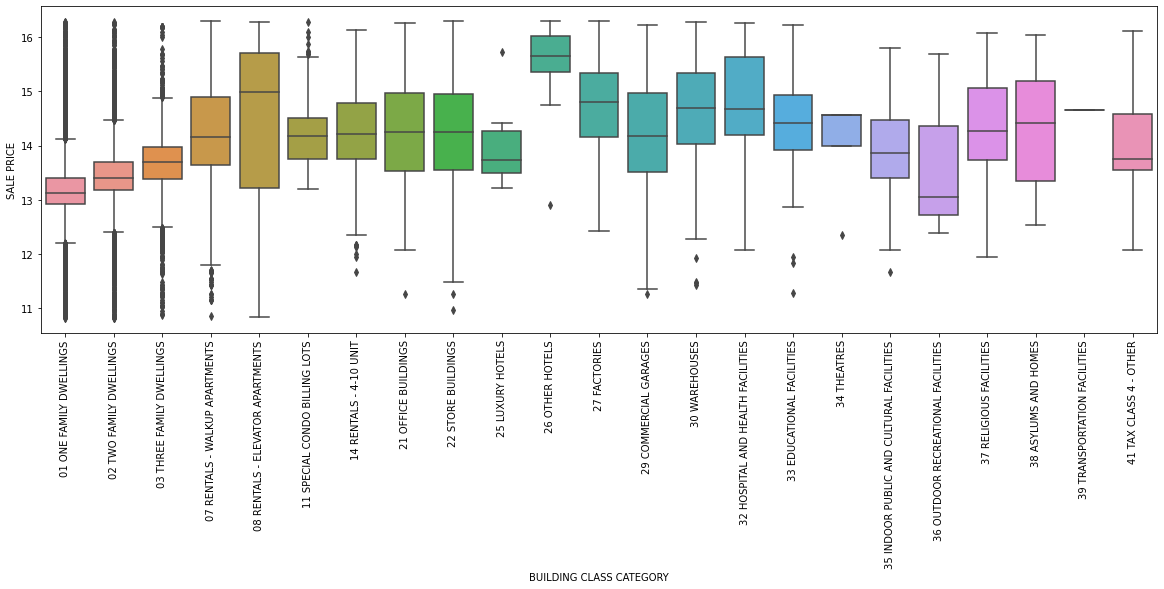

In [42]:
plt.figure(figsize=(20,6))
order = sorted(df['BUILDING CLASS CATEGORY'].unique())
sns.boxplot(x=df['BUILDING CLASS CATEGORY'], y = df['SALE PRICE'], data=df, order=order)
plt.xticks(rotation = 90)
plt.show()

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_base.py:405: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]


([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  90,
  91,
  92,
  93,
  94,
  95,
  96,
  97,
  98,
  99,
  100,
  101,
  102,
  103,
  104,
  105,
  106,
  107,
  108,
  109,
  110,
  111,
  112,
  113,
  114,
  115,
  116,
  117,
  118,
  119,
  120,
  121,
  122,
  123,
  124,
  125,
  126,
  127,
  128,
  129,
  130,
  131,
  132,
  133,
  134,
  135,
  136,
  137,
  138,
  139,
  140,
  141,
  142,
  143,
  144,
  145,
  146,
  147,
  148,
  149,
  150,
  151,
  152,
  153,
  154,
  155,
  156,
  157,
  15

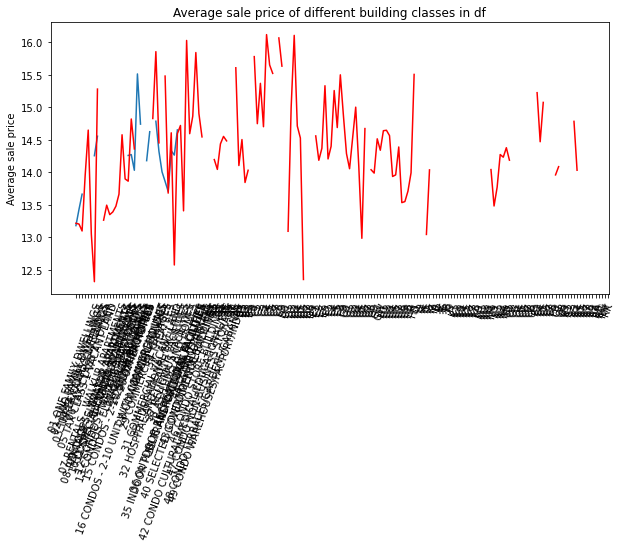

In [43]:
plt.figure(figsize=(10,5))
plt.plot(df.groupby('BUILDING CLASS CATEGORY').mean()['SALE PRICE'])
plt.title('Average sale price of different building classes in df')
plt.ylabel('Average sale price')
plt.xticks(rotation = 70)

plt.plot(df.groupby('BUILDING CLASSAT TIME OF SALE').mean()['SALE PRICE'],color='r')
plt.title('Average sale price of different building classes in df')
plt.ylabel('Average sale price')
plt.xticks(rotation = 70)

In [44]:
df['TAX CLASS AT TIME OF SALE'].value_counts()

1.0    42625
2.0     3399
4.0     2136
Name: TAX CLASS AT TIME OF SALE, dtype: int64

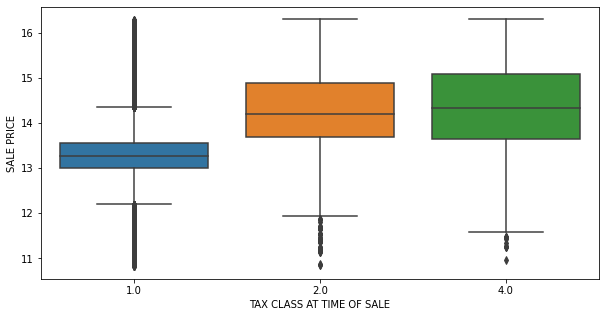

In [45]:
plt.figure(figsize=(10,5))
sns.boxplot(x=df['TAX CLASS AT TIME OF SALE'], y = df['SALE PRICE'], data=pd.melt(df))
plt.show()

In [46]:
## Block and Lot

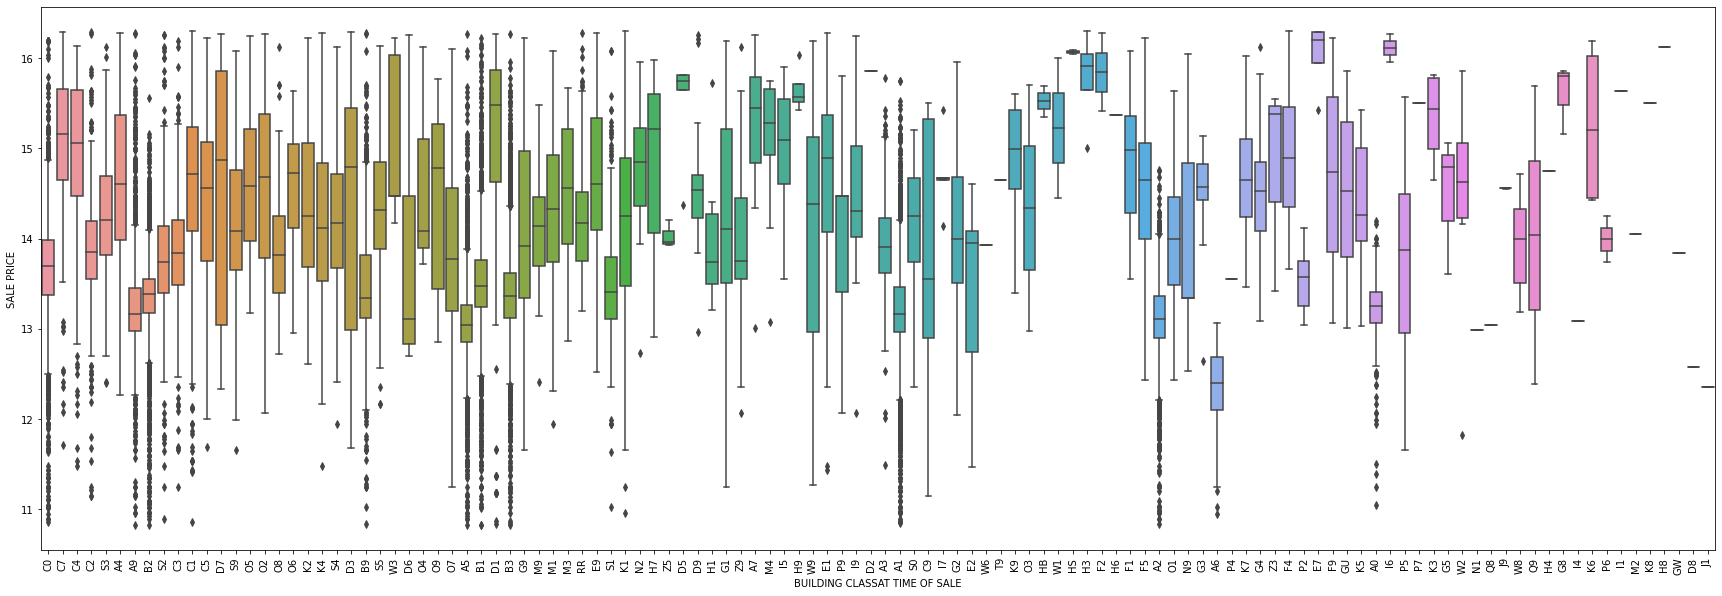

In [47]:
plt.figure(figsize=(30,10))
order = df['BUILDING CLASSAT TIME OF SALE'].unique()
sns.boxplot(x='BUILDING CLASSAT TIME OF SALE', y='SALE PRICE', data=df, order = order)
plt.xticks(rotation=90)
plt.show()

Text(0.5, 0, 'Year Built')

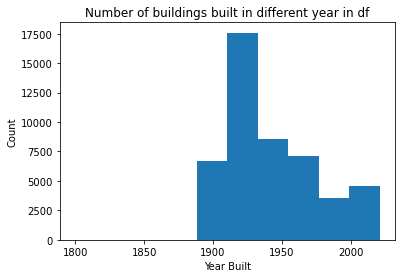

In [48]:
plt.hist(df['YEAR BUILT'])
plt.title('Number of buildings built in different year in df')
plt.ylabel('Count')
plt.xlabel("Year Built")

Text(0, 0.5, 'Average or Median sale price')

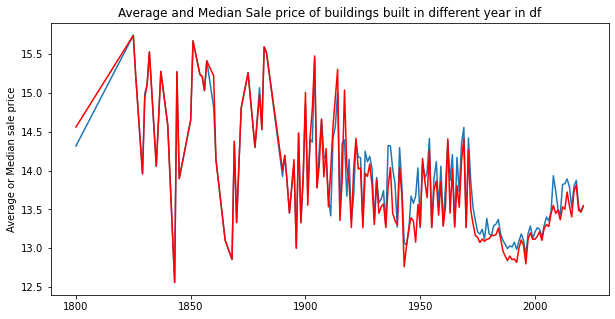

In [49]:
plt.figure(figsize=(10,5))
plt.plot(df.groupby('YEAR BUILT').mean()['SALE PRICE'])
plt.plot(df.groupby('YEAR BUILT').median()['SALE PRICE'],color='r')
plt.title('Average and Median Sale price of buildings built in different year in df')
plt.ylabel('Average or Median sale price')

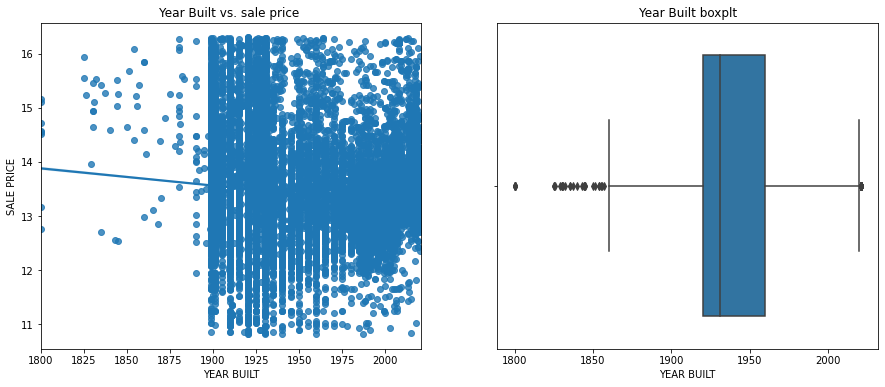

In [50]:
# Year Built
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)

sns.regplot(x='YEAR BUILT', y='SALE PRICE',data=df)
plt.title('Year Built vs. sale price ')
plt.subplot(1,2,2)
sns.boxplot(x= 'YEAR BUILT', data=df)
plt.title('Year Built boxplt')
plt.show()

In [51]:
df['RESIDENTIALUNITS'].max()

8764.0

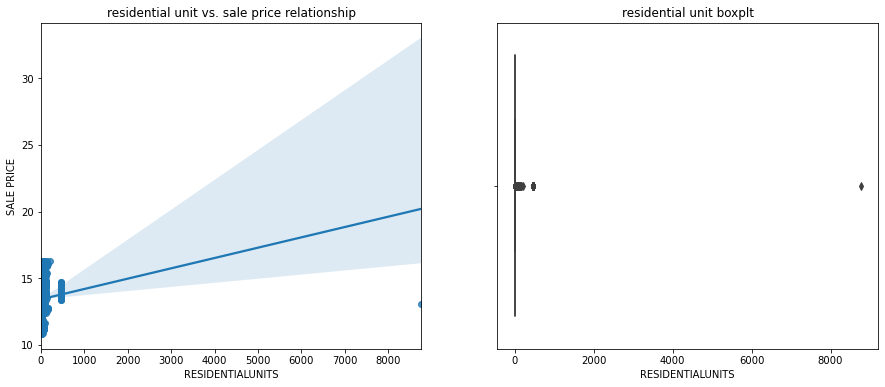

In [52]:
# residential_units
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
sns.regplot(x='RESIDENTIALUNITS', y='SALE PRICE',data=df)
plt.title('residential unit vs. sale price relationship')
plt.subplot(1,2,2)
sns.boxplot(x='RESIDENTIALUNITS', data=df)
plt.title('residential unit boxplt')
plt.show()

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'Frequency')

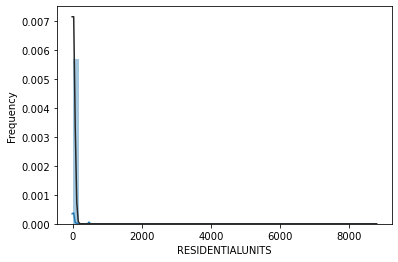

In [53]:
#density plot
sns.distplot(df['RESIDENTIALUNITS'],fit = stats.norm)
plt.ylabel('Frequency')

<Figure size 1080x432 with 0 Axes>

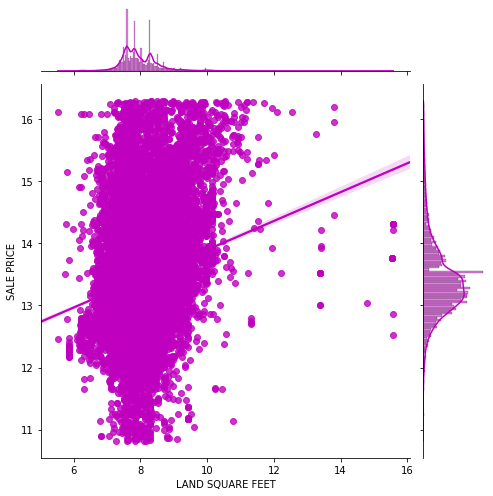

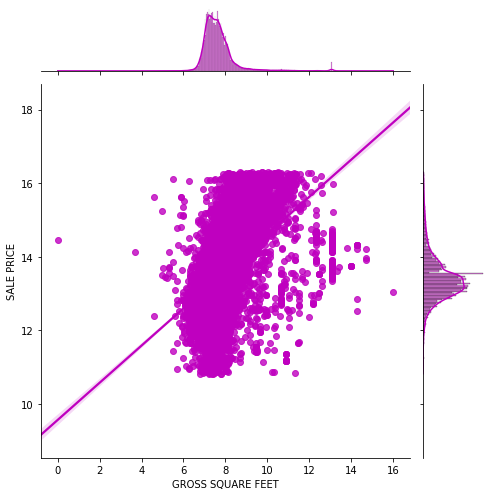

In [54]:
df['LAND SQUARE FEET']=np.log(df['LAND SQUARE FEET'])
df['GROSS SQUARE FEET']=np.log(df['GROSS SQUARE FEET'])
plt.figure(figsize=(15,6));
a=sns.jointplot(x="LAND SQUARE FEET", y="SALE PRICE", data=df,
                  kind="reg", truncate=False,
                  color="m", height=7);
b=sns.jointplot(x="GROSS SQUARE FEET", y="SALE PRICE", data=df,
                  kind="reg", truncate=False,
                  color="m", height=7);

### 3.3 Summary

Based on previous data visulization and analysis, we will drop these features: 

NEIGHBORHOOD, ADDRESS, APARTMENT NUMBER, BLOCK, LOT, ZIP CODE, BLOCK, TAX CLASS AS OF FINAL ROLL 18/19, 
BUILDING AS OF FINAL ROLL 18/19 

In [55]:
df = df.drop(columns=["ADDRESS", "APARTMENT NUMBER", "LOT", "ZIP CODE", "BLOCK", 
                        "NEIGHBORHOOD", "TAX CLASS AT TIME OF SALE",
                        "BUILDING CLASSAT TIME OF SALE"])

In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48160 entries, 2 to 181033
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   BOROUGH                    48160 non-null  category
 1   BUILDING CLASS CATEGORY    48160 non-null  category
 2   TAX CLASS AT PRESENT       48160 non-null  category
 3   BUILDING CLASS AT PRESENT  48160 non-null  category
 4   RESIDENTIALUNITS           48160 non-null  float64 
 5   COMMERCIALUNITS            48160 non-null  float64 
 6   TOTAL UNITS                48160 non-null  float64 
 7   LAND SQUARE FEET           48160 non-null  float64 
 8   GROSS SQUARE FEET          48160 non-null  float64 
 9   YEAR BUILT                 48160 non-null  float64 
 10  SALE PRICE                 48160 non-null  float64 
 11  AGE_CATEGORY               48160 non-null  category
dtypes: category(5), float64(7)
memory usage: 4.5 MB


In [57]:
categoricals= ['BOROUGH', 'BUILDING CLASS AT PRESENT','TAX CLASS AT PRESENT',
               'BUILDING CLASS CATEGORY','AGE_CATEGORY']
one_hot_encoded = pd.get_dummies(df[categoricals])
df_new = df.drop(categoricals,axis = 1)
df_new = df_new.join(one_hot_encoded).reset_index()
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48160 entries, 0 to 48159
Columns: 235 entries, index to AGE_CATEGORY_1
dtypes: float64(7), int64(1), uint8(227)
memory usage: 13.4 MB


In [58]:
df_new

,index,RESIDENTIALUNITS,COMMERCIALUNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,SALE PRICE,BOROUGH_Manhattan,BOROUGH_Bronx,BOROUGH_Brooklyn,BOROUGH_Queens,BOROUGH_Staten Island,BUILDING CLASS AT PRESENT_A0,BUILDING CLASS AT PRESENT_A1,BUILDING CLASS AT PRESENT_A2,BUILDING CLASS AT PRESENT_A3,BUILDING CLASS AT PRESENT_A4,BUILDING CLASS AT PRESENT_A5,BUILDING CLASS AT PRESENT_A6,BUILDING CLASS AT PRESENT_A7,BUILDING CLASS AT PRESENT_A8,BUILDING CLASS AT PRESENT_A9,BUILDING CLASS AT PRESENT_B1,BUILDING CLASS AT PRESENT_B2,BUILDING CLASS AT PRESENT_B3,BUILDING CLASS AT PRESENT_B9,BUILDING CLASS AT PRESENT_C0,BUILDING CLASS AT PRESENT_C1,BUILDING CLASS AT PRESENT_C2,BUILDING CLASS AT PRESENT_C3,BUILDING CLASS AT PRESENT_C4,BUILDING CLASS AT PRESENT_C5,BUILDING CLASS AT PRESENT_C6,BUILDING CLASS AT PRESENT_C7,BUILDING CLASS AT PRESENT_C8,BUILDING CLASS AT PRESENT_C9,BUILDING CLASS AT PRESENT_D0,BUILDING CLASS AT PRESENT_D1,BUILDING CLASS AT PRESENT_D2,BUILDING CLASS AT PRESENT_D3,BUILDING CLASS AT PRESENT_D4,BUILDING CLASS AT PRESENT_D5,BUILDING CLASS AT PRESENT_D6,BUILDING CLASS AT PRESENT_D7,BUILDING CLASS AT PRESENT_D8,BUILDING CLASS AT PRESENT_D9,BUILDING CLASS AT PRESENT_E1,BUILDING CLASS AT PRESENT_E2,BUILDING CLASS AT PRESENT_E7,BUILDING CLASS AT PRESENT_E9,BUILDING CLASS AT PRESENT_F1,BUILDING CLASS AT PRESENT_F2,BUILDING CLASS AT PRESENT_F4,BUILDING CLASS AT PRESENT_F5,BUILDING CLASS AT PRESENT_F8,BUILDING CLASS AT PRESENT_F9,BUILDING CLASS AT PRESENT_G0,BUILDING CLASS AT PRESENT_G1,BUILDING CLASS AT PRESENT_G2,BUILDING CLASS AT PRESENT_G3,BUILDING CLASS AT PRESENT_G4,BUILDING CLASS AT PRESENT_G5,BUILDING CLASS AT PRESENT_G6,BUILDING CLASS AT PRESENT_G7,BUILDING CLASS AT PRESENT_G8,BUILDING CLASS AT PRESENT_G9,BUILDING CLASS AT PRESENT_GU,BUILDING CLASS AT PRESENT_GW,BUILDING CLASS AT PRESENT_H1,BUILDING CLASS AT PRESENT_H2,BUILDING CLASS AT PRESENT_H3,BUILDING CLASS AT PRESENT_H4,BUILDING CLASS AT PRESENT_H6,BUILDING CLASS AT PRESENT_H7,BUILDING CLASS AT PRESENT_H8,BUILDING CLASS AT PRESENT_H9,BUILDING CLASS AT PRESENT_HB,BUILDING CLASS AT PRESENT_HR,BUILDING CLASS AT PRESENT_HS,BUILDING CLASS AT PRESENT_I1,BUILDING CLASS AT PRESENT_I2,BUILDING CLASS AT PRESENT_I5,BUILDING CLASS AT PRESENT_I6,BUILDING CLASS AT PRESENT_I7,BUILDING CLASS AT PRESENT_I9,BUILDING CLASS AT PRESENT_J1,BUILDING CLASS AT PRESENT_J2,BUILDING CLASS AT PRESENT_J6,BUILDING CLASS AT PRESENT_J8,BUILDING CLASS AT PRESENT_J9,BUILDING CLASS AT PRESENT_K1,BUILDING CLASS AT PRESENT_K2,BUILDING CLASS AT PRESENT_K3,BUILDING CLASS AT PRESENT_K4,BUILDING CLASS AT PRESENT_K5,BUILDING CLASS AT PRESENT_K6,BUILDING CLASS AT PRESENT_K7,BUILDING CLASS AT PRESENT_K8,BUILDING CLASS AT PRESENT_K9,BUILDING CLASS AT PRESENT_M1,BUILDING CLASS AT PRESENT_M2,BUILDING CLASS AT PRESENT_M3,BUILDING CLASS AT PRESENT_M4,BUILDING CLASS AT PRESENT_M9,BUILDING CLASS AT PRESENT_N1,BUILDING CLASS AT PRESENT_N2,BUILDING CLASS AT PRESENT_N4,BUILDING CLASS AT PRESENT_N9,BUILDING CLASS AT PRESENT_O1,BUILDING CLASS AT PRESENT_O2,BUILDING CLASS AT PRESENT_O3,BUILDING CLASS AT PRESENT_O4,BUILDING CLASS AT PRESENT_O5,BUILDING CLASS AT PRESENT_O6,BUILDING CLASS AT PRESENT_O7,BUILDING CLASS AT PRESENT_O8,BUILDING CLASS AT PRESENT_O9,BUILDING CLASS AT PRESENT_P2,BUILDING CLASS AT PRESENT_P4,BUILDING CLASS AT PRESENT_P5,BUILDING CLASS AT PRESENT_P6,BUILDING CLASS AT PRESENT_P7,BUILDING CLASS AT PRESENT_P8,BUILDING CLASS AT PRESENT_P9,BUILDING CLASS AT PRESENT_Q1,BUILDING CLASS AT PRESENT_Q8,BUILDING CLASS AT PRESENT_Q9,BUILDING CLASS AT PRESENT_R1,BUILDING CLASS AT PRESENT_R2,BUILDING CLASS AT PRESENT_R3,BUILDING CLASS AT PRESENT_R4,BUILDING CLASS AT PRESENT_R5,BUILDING CLASS AT PRESENT_R6,BUILDING CLASS AT PRESENT_R7,BUILDING CLASS AT PRESENT_R8,BUILDING CLASS AT PRESENT_R9,BUILDING CLASS AT PRESENT_RA,BUILDING CLASS AT PRESENT_RB,BUILDING CLASS AT PRESENT_RG,BUILDING CLASS AT PRESENT_RH,BUILDING CLASS AT PRESENT_RK,BUILDING CLASS AT PRESENT_RP,BUILDING CLASS AT PRESENT_RR,BUILDI

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'log(LAND SQUARE FEET) density plot')

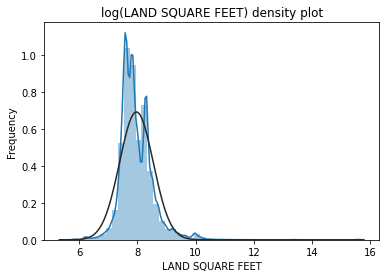

In [59]:
#density plot
sns.distplot(df_new['LAND SQUARE FEET'],fit = stats.norm)
plt.ylabel('Frequency')
plt.title("log(LAND SQUARE FEET) density plot")

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'log(GROSS SQUARE FEET) density plot')

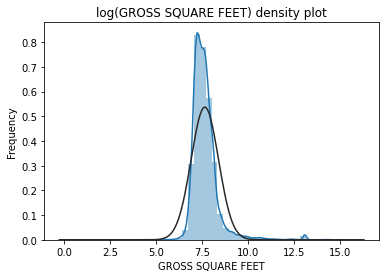

In [60]:
#density plot
sns.distplot(df_new['GROSS SQUARE FEET'],fit = stats.norm)
plt.ylabel('Frequency')
plt.title("log(GROSS SQUARE FEET) density plot")

In [61]:
from sklearn.model_selection import train_test_split

X = df_new.drop('SALE PRICE', axis = 1)
y = df_new['SALE PRICE']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)

# Linear regression

In [62]:
from sklearn.linear_model import LinearRegression
from sklearn import metrics

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

LinearRegression()

MSE: 0.25301541349294193
RMSE: 0.5030063752010921
R-square 0.47413117988412823


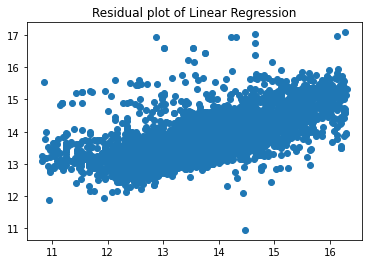

In [63]:
pred_linear = lr_model.predict(X_test)
plt.scatter(y_test, pred_linear)
plt.title('Residual plot of Linear Regression')
print('MSE:', metrics.mean_squared_error(y_test, pred_linear))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, pred_linear)))
print('R-square', metrics.r2_score(y_test, pred_linear))

# Decision Tree

In [64]:
from sklearn.tree import DecisionTreeRegressor
dr = DecisionTreeRegressor()
dr.fit(X_train,y_train)

DecisionTreeRegressor()

MSE: 0.3359407740202705
RMSE: 0.5796039803350823
R-square 0.30177859117748784


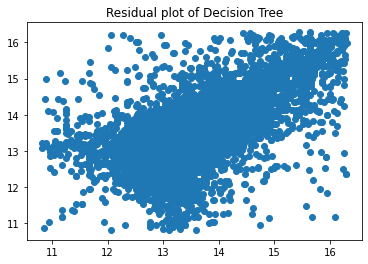

In [65]:
pred_dr = dr.predict(X_test)
plt.scatter(y_test, pred_dr)
plt.title('Residual plot of Decision Tree')
print('MSE:', metrics.mean_squared_error(y_test, pred_dr))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, pred_dr)))
print('R-square', metrics.r2_score(y_test, pred_dr))

# Random forest

In [66]:
from sklearn.ensemble import RandomForestRegressor
rg = RandomForestRegressor()
rg.fit(X_train,y_train)

RandomForestRegressor()

MSE: 0.1761865491778732
RMSE: 0.4197458149617137
R-square 0.6338127726790062


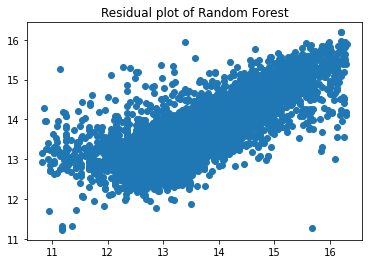

In [67]:
pred_rg = rg.predict(X_test)
plt.scatter(y_test, pred_rg)
plt.title('Residual plot of Random Forest')
print('MSE:', metrics.mean_squared_error(y_test, pred_rg))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, pred_rg)))
print('R-square', metrics.r2_score(y_test, pred_rg))

# XGBoost

In [68]:
# from xgboost import XGBRegressor
# xgb = XGBRegressor(tree_method="gpu_hist",enable_categorical=True)
# xgb.fit(X_train,y_train)

In [69]:
# pred_xgb = xgb.predict(X_test)
# plt.scatter(y_test, pred_xgb)
# plt.title('Residual plot of XGBoost')
# print('MSE:', metrics.mean_squared_error(y_test, pred_xgb))
# print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, pred_xgb)))
# print('R-square', metrics.r2_score(y_test, pred_xgb))

# Lasso Regression

MAE: 0.40014625310519353
MSE: 0.3391057305947601
RMSE: 0.582327854901996
R-square 0.29520052560998733


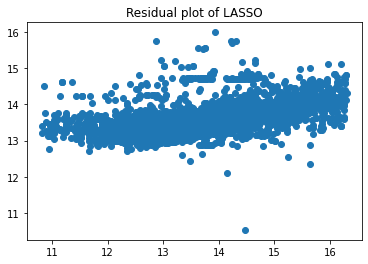

In [70]:
from sklearn.linear_model import Lasso

lasso_reg = Lasso(alpha = 0.1)
lasso_reg.fit(X_train, y_train)
lasso_reg_predict = lasso_reg.predict(X_test)

plt.scatter(y_test, lasso_reg_predict)
plt.title('Residual plot of LASSO')
print('MAE:', metrics.mean_absolute_error(y_test, lasso_reg_predict))
print('MSE:', metrics.mean_squared_error(y_test, lasso_reg_predict))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, lasso_reg_predict)))
print('R-square', metrics.r2_score(y_test, lasso_reg_predict))

# Ridge Regression

MAE: 0.32770478718360607
MSE: 0.2524427629744065
RMSE: 0.502436824859013
R-square 0.4753213803085359


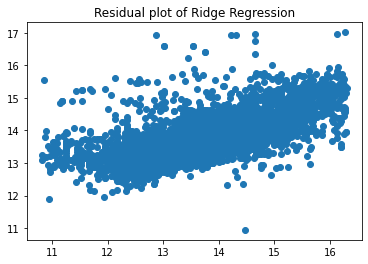

In [71]:
from sklearn.linear_model import Ridge

ridge_reg = Ridge(alpha = 0.1)
ridge_reg.fit(X_train, y_train)
ridge_reg_predict = ridge_reg.predict(X_test)

plt.scatter(y_test, ridge_reg_predict)
plt.title('Residual plot of Ridge Regression')
print('MAE:', metrics.mean_absolute_error(y_test, ridge_reg_predict))
print('MSE:', metrics.mean_squared_error(y_test, ridge_reg_predict))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, ridge_reg_predict)))
print('R-square', metrics.r2_score(y_test, ridge_reg_predict))

# Robust Regression

In [72]:
from sklearn.model_selection import cross_val_score

def cross_val(model):
    pred = cross_val_score(model, X, y, cv=10)
    return pred.mean()

def print_evaluate(true, predicted):  
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    print('MAE:', mae)
    print('MSE:', mse)
    print('RMSE:', rmse)
    print('R2 Square', r2_square)
    
def evaluate(true, predicted):
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    return mae, mse, rmse, r2_square

Test set evaluation:
_____________________________________
MAE: 0.3664428873709165
MSE: 1.6688195443910692
RMSE: 1.2918279856045345
R2 Square -2.4684849933844806
Train set evaluation:
_____________________________________
MAE: 0.37914723317136567
MSE: 13.339624790513703
RMSE: 3.652345108353495
R2 Square -26.90075934157102


Text(0.5, 1.0, 'Residual plot of Robust Regression')

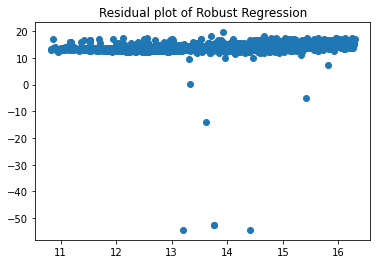

In [73]:
from sklearn.linear_model import RANSACRegressor

model = RANSACRegressor(max_trials=1000)
model.fit(X_train, y_train)

test_pred = model.predict(X_test)
train_pred = model.predict(X_train)

print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, test_pred)
print('====================================')
print('Train set evaluation:\n_____________________________________')
print_evaluate(y_train, train_pred)

plt.scatter(y_test, test_pred)
plt.title('Residual plot of Robust Regression')